# Offline diagnostics for single output networks following Rasp et al. (2018) architecture

# Shapley Values

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from utils.pcmci_aggregation import get_matrix_idx, get_matrix_insets_idx, get_matrix_2d_idx
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.variable import Variable_Lev_Metadata
from utils.constants import SPCAM_Vars
from utils.plotting import plot_matrix, plot_matrix_insets

In [5]:
from pathlib import Path
import pickle
import datetime
import time
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Setup

In [6]:
PROJECT_ROOT = Path.cwd().parent.resolve()
# PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

# base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001/") 
# cfg = os.path.join(base_dir, "cfg_pre_mask_net.yml")

# training_88_mask_net_prediction_thresholds_spars1.0
# training_89_mask_net_prediction_thresholds_spars0.1
# training_90_mask_net_prediction_thresholds_spars0.01
# training_91_mask_net_prediction_thresholds_spars0.001
# training_92_mask_net_prediction_thresholds_spars1e-4
# training_93_mask_net_prediction_thresholds_spars1e-5

# "training_95_mask_net_prediction_thresholds_spars1.0"
# "training_96_mask_net_prediction_thresholds_spars0.1"
# "training_97_mask_net_prediction_thresholds_spars0.01"
# "training_98_mask_net_prediction_thresholds_spars0.001"
# "training_99_mask_net_prediction_thresholds_spars1e-4"
# "training_100_mask_net_prediction_thresholds_spars1e-5"

# training_103_mask_net_prediction_thresholds_spars0.001_plus4k
# training_104_mask_net_prediction_thresholds_spars0.001_minus4k
# training_105_mask_net_prediction_thresholds_spars0.001_plus4k_ref
# training_106_mask_net_prediction_thresholds_spars0.001_minus4k_ref

# training_109_mask_net_prediction_thresholds_spars0.001_plus4k_ref2_train
# training_110_mask_net_prediction_thresholds_spars0.001_plus4k_ref2_val
# training_111_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_train
# training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val


base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val") 
train_val = "val"

num_inputs_file = os.path.join(PROJECT_ROOT, "output_castle", "training_91_mask_net_prediction_thresholds_spars0.001", 
                               "threshold_performance", f"num_inputs_per_var_{train_val}.p")

single_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "single_nn") 
single_cfg = os.path.join(single_base_dir, "cfg_single_nn_diagnostics.yml")

if "prediction_thresholds" in base_dir and not "_ref2" in base_dir: 
    cfg = os.path.join(base_dir, f"cfg_mask_net_thresholds_{train_val}.yml")
else: 
    cfg = os.path.join(base_dir, "cfg_mask_net.yml")




In [7]:
if "prediction_thresholds" in base_dir and not "_ref2" in base_dir:
    mask_num_inputs_file = os.path.join(base_dir, "threshold_performance", f"num_inputs_per_var_{train_val}.p")
    
elif "prediction_thresholds" in base_dir and "_ref2" in base_dir:
    mask_num_inputs_file = num_inputs_file
    
else:
    mask_num_inputs_file = os.path.join(PROJECT_ROOT, "output_castle", 
                                        "training_81_pre_mask_net_spars1e-5", 
                                        "bespoke_thresholds", "num_inputs_per_var.p")

In [8]:
base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                              "models_arch-rasp_thrs-opt-mse6") 
cfg = os.path.join(base_dir, "cfg_causal_single_nn_diagnostics.yml")


In [9]:
if "prediction_thresholds" in Path(base_dir).name and not "_ref2" in base_dir:
    shap_dict_dir = Path(base_dir, "plots_offline_evaluation", f"shap_{train_val}", "range-all_samples-1000_all")
else:
    shap_dict_dir = Path(base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
outputs_map_file = Path(base_dir, "outputs_map.txt")

In [10]:
def get_setup(config):
    argv  = ["-c", config]
    
    return SetupDiagnostics(argv)

In [11]:
setup = get_setup(cfg)
single_setup = get_setup(single_cfg)

## Load Shapley dictionaries

In [12]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [13]:
def load_shap_dict(shap_dir, outputs_map):
    outputs_varname2save = parse_txt_to_dict(outputs_map)
    outputs_save2varname = {value: key for key, value in outputs_varname2save.items()}
    
    shap_dict_per_var = {}
    for file in glob.glob(str(shap_dir) + "/*.p"):
        with open(file, "rb") as f:
            d = pickle.load(f)
        var_save_key = re.findall(r"[0-9]_[0-9]+",Path(file).name)[0]
        shap_dict_per_var[Variable_Lev_Metadata.parse_var_name(outputs_save2varname[var_save_key])] = d
    return shap_dict_per_var


In [14]:
shap_dict_per_var = load_shap_dict(shap_dict_dir, outputs_map_file)
len(shap_dict_per_var.keys())

63

In [15]:
for var, shap in shap_dict_per_var.items():
    print(f"\nvar: {var}")
    print(f"shap values abs mean: \n{shap['shap_values_abs_mean']}\n")


var: phq-763.4
shap values abs mean: 
[6.43581730e-05 1.80143540e-02 2.11608728e-02 2.29526655e-01
 8.23461771e-02 5.23138263e-02 1.58374884e-02 1.28949220e-02
 2.43561211e-02 2.32870298e-02 3.31362250e-02 3.71110095e-02
 1.34251594e-01 7.88132928e-02 8.25204595e-02 3.44850910e-02
 5.13290765e-02 3.58535258e-02 1.68809772e-02 6.49838175e-03
 2.01175469e-02 3.25958384e-02 2.20260760e-04 2.66035309e-03
 3.60717420e-03 2.42403968e-03 2.11614820e-03 1.75383080e-03
 2.32003950e-03 3.53098392e-03 1.58082189e-03 2.64187140e-03
 2.68284501e-03 1.81692588e-03 1.44901388e-03 4.56923798e-03
 1.25242518e-02]


var: tphystnd-3.64
shap values abs mean: 
[1.72306195e-06 1.19625063e-06 1.33461880e-06 4.54125853e-07
 2.76820473e-07 1.45291185e-06 4.56935299e-06 1.53467783e-05
 5.13690054e-05 1.32595978e-04 6.91669407e-05 1.84785488e-04
 1.13739725e-04 1.22886932e-04 1.44356978e-04 1.27006511e-04
 1.76826614e-04 1.78580774e-04 1.06433829e-03 1.36442089e-03
 2.36109800e-03 1.18390823e-03 5.92838126e-04 

## Calculate SHAP matrix

In [16]:
def generate_output_vars(setup):
    output_list = list()
    # Use setup.output_order here instead of setup.spcam_outputs to get the right order of variables
    for spcam_var in setup.spcam_outputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.children_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                # For CausalSingleNN, there are no networks for variables phq-3.64 and phq-7.59
                if setup.nn_type == "CausalSingleNN" and (var_name == "phq-3.64" or var_name == "phq-7.59"):
                    continue
                output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return output_list

In [17]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)
    

In [18]:
def calculate_shap_matrix(setup, shap_dict_per_var, metric):
    output_vars = {i: var for i, var in enumerate(generate_output_vars(single_setup))}
    input_vars = generate_input_vars(setup)
    
    num_inputs = len(input_vars)
    
    input_inverse_idx = list(range(num_inputs-1, -1, -1))
    input_inverse_idx2var = {i: input_vars[num_inputs - 1 - i] for i in range(num_inputs)}
    
    
    metric_key = "shap_values_" + metric
    shap_matrix = np.ma.zeros([len(output_vars), len(input_vars)])

    
    for i, var in output_vars.items():
        if setup.nn_type == "CausalSingleNN" and (str(var) == "phq-3.64" or str(var) == "phq-7.59"):
            # No causal drivers were found for these variables
            continue
            
        var_inputs_idx = {input: idx for idx, input in enumerate(shap_dict_per_var[var]["inputs"])}
        for k in range(num_inputs):
            j = input_inverse_idx[k]
            # Check if this input is an input for the current variables
            try: 
                shap_matrix[i, k] = shap_dict_per_var[var][metric_key][var_inputs_idx[j]]
            except KeyError: 
                # This means the input was not part of the variables network inputs
                pass
            
    return shap_matrix, input_inverse_idx2var, output_vars


## Plot SHAP matrix

In [19]:
def plot_matrix_shap(clima_case, nn_case, metric, input_dict_inv_remap_var,  dict_outputs_idxs, 
                     shap_matrix, diff=False, save=False, savenm=False, cmap=False, 
                     extend=False, interpolation='none', insets=False, num_parents=False, **kwargs):
    # diff doesn't do anything
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_insets_idx(input_dict_inv_remap_var, inverted=True)
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_insets_idx(dict_outputs_idxs, insets=insets)


    # Plotting
    if diff is False and 'abs' in metric and 'sign' not in metric:
        # norm = colors.LogNorm(vmin=0., vmax=shap_matrix.max())
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=shap_matrix.min(), vmax=shap_matrix.max(), base=10)
        # norm = colors.PowerNorm(gamma=0.2)
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=0., vmax=shap_matrix.max(), base=10)
        if not cmap: cmap='Reds'
        if not extend: extend='max'
    
    else:
        maximum = max(abs(shap_matrix.max()), abs(shap_matrix.min()))
        vmax=maximum; vmin=-1*maximum
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=vmin, vmax=vmax, base=10)
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
        if not cmap: cmap='RdBu_r'
        if not extend: extend='both'
        
    cbar_label='SHAP values'
    
    if insets:
        out_vars_2d, out_vars_2d_ticks = get_matrix_2d_idx(dict_outputs_idxs)
        fig, ax = plot_matrix_insets(None, shap_matrix, 
                                     in_vars, in_box_idx, in_ticks, in_ticks_labs,
                                     out_vars, out_box_idx,out_ticks, out_ticks_labs,
                                     out_vars_2d, out_vars_2d_ticks, 
                                     extend, cbar_label, 
                                     dict_outputs_idxs=dict_outputs_idxs,
                                     mask=False,num_parents=False, 
                                     # vmin=vmin,
                                     # vmax=vmax,
                                     cmap=cmap,
                                     # norm=colors.CenteredNorm(),
                                     # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10) 
                                     norm=norm,
                                     interpolation=interpolation, )
    else:
        fig, ax = plot_matrix(None, shap_matrix,
                              in_vars, in_box_idx, in_ticks, in_ticks_labs,
                              out_vars, out_box_idx, out_ticks,  out_ticks_labs,
                              extend, cbar_label, mask=False, num_parents=num_parents,
                              # vmin=vmin,
                              # vmax=vmax,
                              cmap=cmap,
                              # norm=colors.CenteredNorm(),
                              # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
                              norm=norm,
                              interpolation=interpolation, 
                              )
    ax.set_rasterized(True)
    
    if save:
        Path(save).mkdir(parents=True, exist_ok=True)
        
        if not num_parents:
            f_name = f'SHAP_values_{nn_case}_{clima_case}_{metric}' if not savenm else savenm
        else: 
            f_name = f'SHAP_values_{nn_case}_{clima_case}_{metric}_num_inputs' if not savenm else savenm
            
        fig.savefig(f"{save}/{f_name}.pdf", format="pdf", bbox_inches="tight", transparent=True)
        # fig.savefig(f"{save}/{f_name}.png", dpi=600, bbox_inches='tight', transparent="True")
        
        print(f"Saved Shapley matrix {save}/{f_name}")
    return fig, ax

## Plot SHAP matrices

In [20]:
output_dir = os.path.join(shap_dict_dir, "plots")
print(output_dir)

/work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/plots_offline_evaluation/shap/range-all_samples-1000_all/plots


In [21]:
metric = "abs_mean"
shap_matrix_abs_mean, input_inverse_idx2var_abs_mean, output_vars_abs_mean = \
    calculate_shap_matrix(setup, shap_dict_per_var, metric)
shap_matrix_abs_mean.shape

(65, 94)

Saved Shapley matrix /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/plots_offline_evaluation/shap/range-all_samples-1000_all/plots/SHAP_values_causal_nn_0K_abs_mean


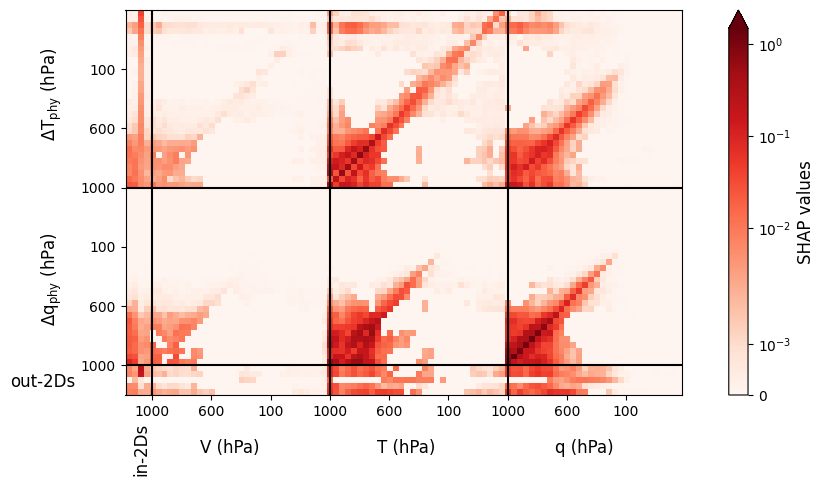

In [22]:
fig_abs_mean, ax_abs_mean = plot_matrix_shap("0K", "causal_nn", metric, input_inverse_idx2var_abs_mean, output_vars_abs_mean, shap_matrix_abs_mean, save=output_dir)


Saved Shapley matrix /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/plots_offline_evaluation/shap/range-all_samples-1000_all/plots/SHAP_values_causal_nn_0K_abs_mean_sign


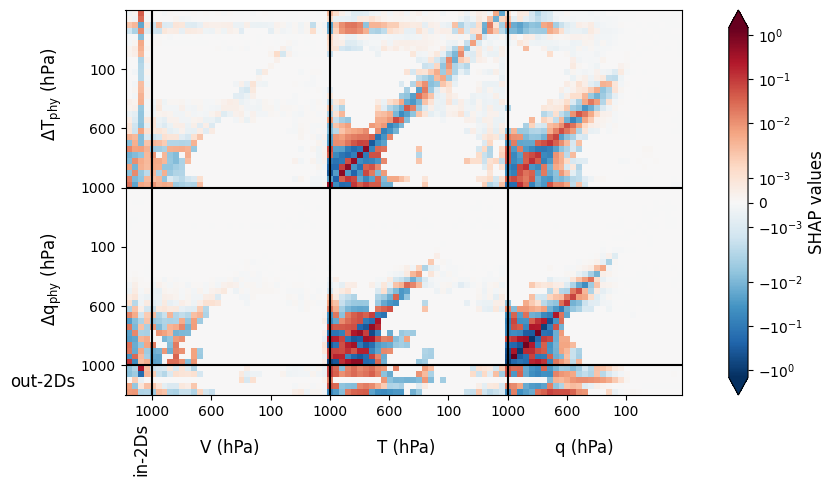

In [23]:
metric = "abs_mean_sign"
shap_matrix_abs_mean_sign, input_inverse_idx2var_abs_mean_sign, output_vars_abs_mean_sign = calculate_shap_matrix(setup, shap_dict_per_var, metric)
fig_abs_mean_sign, ax_abs_mean_sign = plot_matrix_shap("0K", "causal_nn", metric, input_inverse_idx2var_abs_mean_sign, output_vars_abs_mean_sign, shap_matrix_abs_mean_sign, save=output_dir)


## Plot with number of inputs

In [98]:
causal_num_inputs_file = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6", 
                                      "num_inputs_per_var.p")
with open(causal_num_inputs_file, "rb") as read_file:
    causal_num_inputs_per_var = pickle.load(read_file)

print(f"Loading num inputs file {mask_num_inputs_file}")
with open(mask_num_inputs_file, "rb") as read_file:
    mask_num_inputs_per_var = pickle.load(read_file)


Loading num inputs file /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/num_inputs_per_var_val.p


In [99]:
num_inputs = {"CI-NN": causal_num_inputs_per_var.values(), 
              "MaskNet": mask_num_inputs_per_var.values()}

In [100]:
metric = "abs_mean"
shap_matrix_abs_mean, input_inverse_idx2var_abs_mean, output_vars_abs_mean = calculate_shap_matrix(setup, shap_dict_per_var, metric)


In [101]:
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val/plots_offline_evaluation/shap/range-all_samples-1000_all/plots


Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val/plots_offline_evaluation/shap/range-all_samples-1000_all/plots/SHAP_values_mask_net_ref2_0K_abs_mean_num_inputs.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


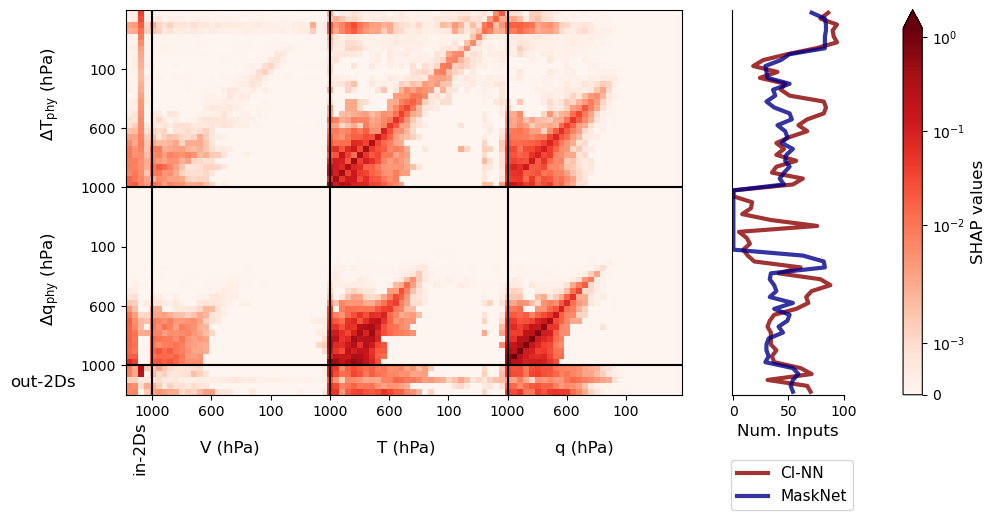

In [102]:
fig_abs_mean, ax_abs_mean = plot_matrix_shap("0K", "mask_net_ref2", metric, input_inverse_idx2var_abs_mean, output_vars_abs_mean, 
                                             shap_matrix_abs_mean, num_parents=num_inputs, save=output_dir)
plt.savefig(os.path.join(output_dir, "SHAP_values_mask_net_ref2_0K_abs_mean_num_inputs.pdf"), format="pdf", bbox_inches="tight")

fig_abs_mean.show()
